## InkClassifer3dCNN from [ink-id](https://github.com/educelab/ink-id/blob/develop/inkid/model/model.py#L536) repo

In this notebook I convert the model used for the baseline score of 0.48 into a kaggle notebook. 

The model takes an input subvolume volume and gives a single pixel prediction. To allow this to make predictions for the test fragments within the computational limits of a kaggle notebook, the pixels are predicted sparsely and the data is extrapolated. e.g. every 19th pixel is predicted and the area surrounding the value will contain copies of the pixels prediction, an example of this type of prediction is shown below (of validation data withheld from the model during training)

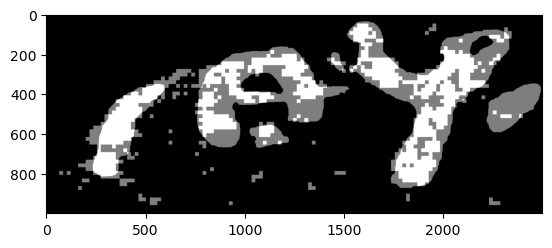


Loading all 3 fragments into memory at once takes up too much memory so I only load 1 at a time, even then the second fragement proves to be large so I split it into patches to train on and iterate through them. The blue rectangles are for training and the red rectangle is for validation (withheld during training).

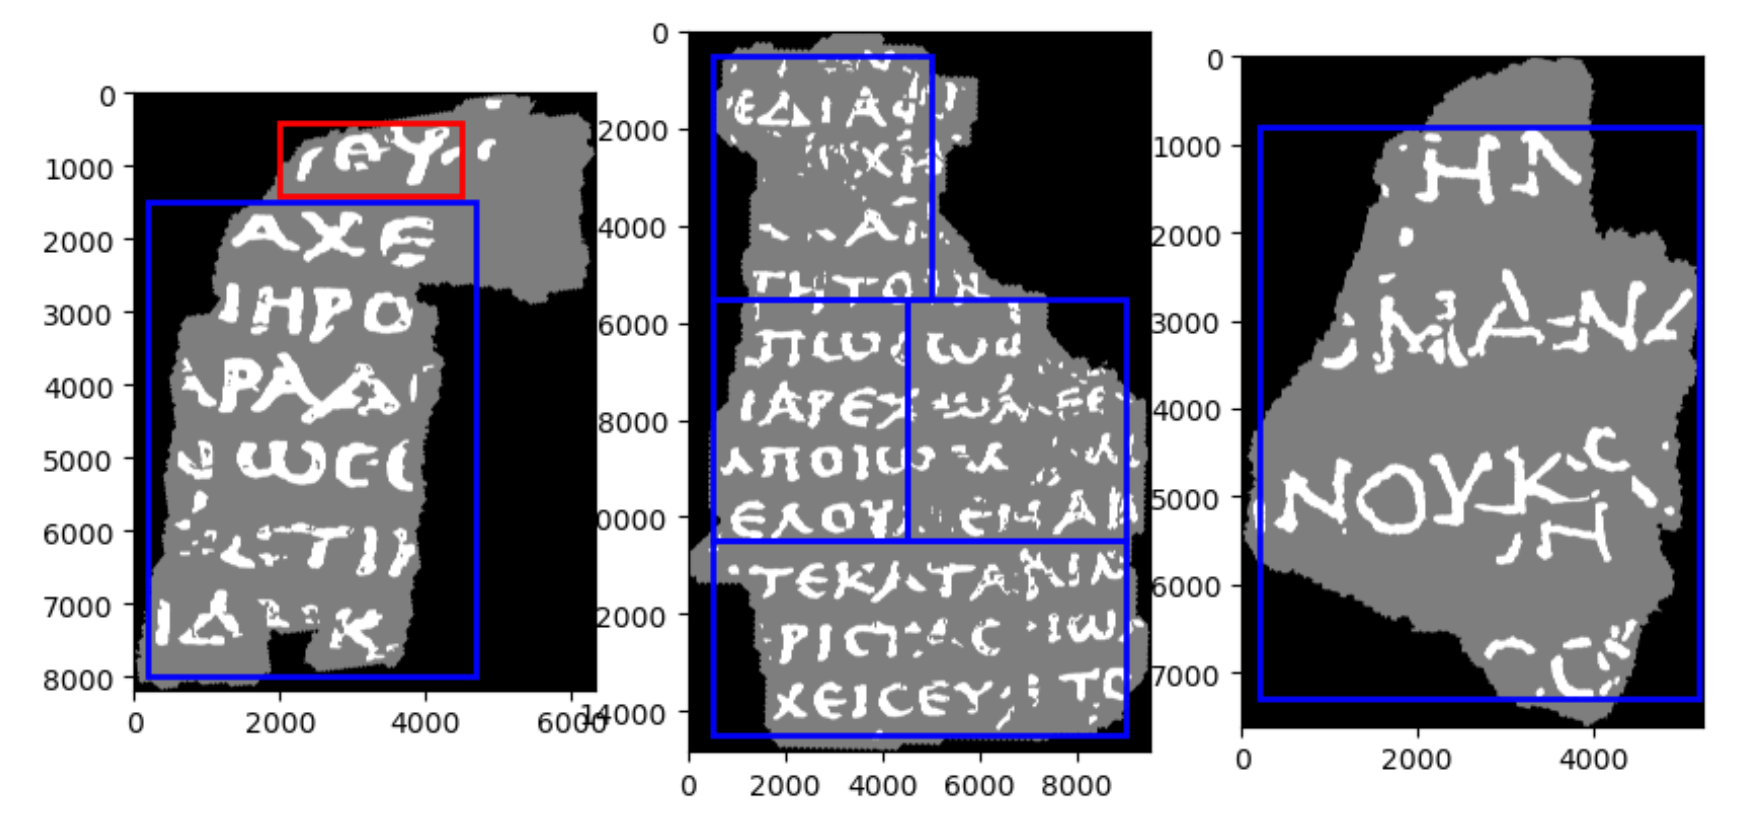


In [1]:
######################## InkClassifier3DCNN Model ########################
import torch
import torch.nn as nn

class Subvolume3DcnnEncoder(nn.Module):
    def __init__(self, batch_norm_momentum, filters):
        super().__init__()
        strides = [1, 2, 2, 2]
        filter_sizes = [1] + filters
        filter_list_pairs = list(zip(filter_sizes[:-1], filter_sizes[1:])) # [(1, 16), (16, 32), (32, 64), (64, 128)]
        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv3d(chan_in, chan_out, kernel_size=3 ,stride=stride, padding=1),
                nn.ReLU(),
                nn.BatchNorm3d(num_features=filter_, momentum=batch_norm_momentum)
            )
                for (chan_in, chan_out), stride, filter_ in zip(filter_list_pairs, strides, filters)])
        self.apply(self.init_weight)

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv3d):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.conv_layers(x)
    
class LinearInkDecoder(nn.Module):

    def __init__(self, input_shape):
        super().__init__()
        self.fc = nn.Linear(int(np.prod(input_shape)), 1)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(self.flatten(x)))# (B, 1) 
    
class InkClassifier3DCNN(nn.Module):
    def __init__(self, subvolume_shape=[256, 256, 10], batch_norm_momentum=0.1, filters=[16, 32, 64, 128]):
        super().__init__()
        self.encoder = Subvolume3DcnnEncoder(batch_norm_momentum, filters)
        self.decoder = LinearInkDecoder(self.encoder(torch.zeros((1, 1, *subvolume_shape))).shape[1:])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
########################################################
# HELPER FUNCTIONS
########################################################
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import os
import time
import PIL
import random
import tqdm
import gc

vesuvius_data_path = '/kaggle/input/vesuvius-challenge-ink-detection/'
device = "cuda:0" if torch.cuda.is_available() else "cpu"

def load_mask_label(fragment, rect = None, display = False):
    """Loads and returns mask and label for a given fragment
    Parameters:
      fragment (int in [1, 2, 3]): id of the fragment
      rect (tuple): (x, y, w, h) of the subsection of the image to load
    """
    mask_filepath = vesuvius_data_path+f"train/{fragment}/mask.png"
    label_filepath = vesuvius_data_path+f"train/{fragment}/inklabels.png"

    mask = cv2.imread(mask_filepath, 0) / 255.
    label = cv2.imread(label_filepath, 0) /255.
    if rect is not None:
        mask = mask[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        label = label[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    return mask, label

def load_image_stack(fragment, Z_START, Z_DIM, rect = None, folder='train', display_all = False, display_one = False):
    root_filepath = vesuvius_data_path+f"{folder}/{fragment}/surface_volume/"
    tif_filepaths = [root_filepath+ x for x in sorted(os.listdir(root_filepath))[:-4]]
    layers_to_use = tif_filepaths[Z_START:Z_START+Z_DIM]
    image_stack = []
    for filepath in layers_to_use:
        loaded_img = torch.Tensor(cv2.imread(filepath, 0) / 65535.0).float().to(device)
        if rect is None:
            image_stack.append(loaded_img)
        else:
            image_stack.append(loaded_img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
    return torch.stack(image_stack, dim=0)
    

def get_pixels(mask, img_size, stride = 0):
    """Returns pixels inside rectangle and mask
    Parameters:
        mask (np.array): mask of the image
        img_size (int): size of the image
        stride (int): how many pixels to skip (e.g. 0 means all pixels, 3 means a gap of 3 horizontally and vertically between pixels)
    """
    radius = int(img_size//2)
    # Create a Boolean array mask of the same shape as the mask, initially all True
    not_border = np.zeros(mask.shape, dtype=bool)
    not_border[radius:mask.shape[0]-radius, radius:mask.shape[1]-radius] = True
    arr_mask = np.array(mask) * not_border

    if stride !=0:
        assert stride % 2 == 1, "stride has to be an odd number!"
        sparse_mask = np.zeros(mask.shape, dtype=bool)
        sparse_mask[::stride, ::stride] = True
        return np.argwhere(sparse_mask*arr_mask)
    
    return np.argwhere(arr_mask)

class SubvolumeDataset(torch.utils.data.Dataset):
    def __init__(self, image_stack, label, pixels, img_size):
        self.image_stack = image_stack
        self.label = torch.Tensor(label).float()
        self.pixels = pixels
        self.radius = int(img_size//2)
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index] 
        subvolume = self.image_stack[:, y-self.radius:y+self.radius, x-self.radius:x+self.radius]
        # ink_label = self.labels[y-self.radius:y+self.radius, x-self.radius:x+self.radius] uncomment this line to use a segmentation model
        ink_label = self.label[y, x]
        return subvolume, ink_label
    
#Subvolume patches to train on
#[fragment_id, subvolume]
#x, y, w, h
test_patches = {1: [2000, 400, 2500, 1000]}

#x, y, w, h
train_patches = [
    [1, [200, 1500, 4500, 6500]],
    [2, [500, 500, 4500, 5000]],
    [2, [500, 5500, 4000, 5000]],
    [2, [4500, 5500, 4500, 5000]],
    [2, [500, 10500, 8500, 4000]],
    [3, [200, 800, 5000, 6500]]]

In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

img_size = 64 # 256
Z_START = 27
Z_DIM = 10

batch_size = 32
lr = 3e-3 

model = InkClassifier3DCNN(subvolume_shape=[img_size, img_size, 10], filters = [16,32,64,128]).to(device)
xb = torch.rand((5,1,img_size,img_size,10)).to(device)
print("forward pass:", model(xb).shape)
print(f"Number of params: {(sum(p.numel() for p in model.parameters() if p.requires_grad)):,}")

total_training_steps = 100000 # (really means 50,000*batch_size steps)
subvolume_training_steps = 2000

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=total_training_steps)

In [ ]:
training_step = 0
t_start = time.time()
model.train()
while training_step < total_training_steps:
    print("-"*20, "New dataloader section", "-"*20)
    random.shuffle(train_patches)
    for fragment, patch in train_patches:
        if training_step >= total_training_steps:
            break
        t_load = time.time()

        mask, label = load_mask_label(fragment, rect = patch)
        image_stack = load_image_stack(fragment, Z_START, Z_DIM, rect = patch)
        pixels = get_pixels(mask, img_size)
        del mask
        dataset = SubvolumeDataset(image_stack, label, pixels, img_size)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        print(f"## Fragment {fragment}, patch {patch}, Taken {time.time() - t_load:.2f}s to load ##")
        dataloader_loss = []
        dataloader_steps = 0
        t_dataloader = time.time()
        for i, (subvolumes, ink_labels) in enumerate(dataloader):
            if dataloader_steps >= subvolume_training_steps or training_step >= total_training_steps:
                break
            ink_labels = ink_labels.to(device)
            logits = model(subvolumes.permute(0, 2, 3, 1).unsqueeze(dim=1))
            loss = loss_fn(logits, ink_labels.unsqueeze(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            dataloader_loss.append(loss.item())
            training_step += 1
            dataloader_steps += 1
        del image_stack, label, dataset, dataloader
        deleted_elements = gc.collect()
        print(f"training step: {training_step} | Dataloader loss: {np.array(dataloader_loss).mean():.4f} | dataloader time: {time.time() - t_dataloader:.2f}s | t_start: {time.time()-t_start:.2f}s | deleted: {deleted_elements}")

In [ ]:
def generate_predictions(fragment = 'a', stride = 99, patch = None):
    """Return predictions for the test fragments
    Parameters:
        fragment: str, 'a' or 'b'
        stride: int, stride for the sliding window
    """
    t_load = time.time()
    if fragment in ['a', 'b']: # test set
        mask_filepath = vesuvius_data_path+f"test/{fragment}/mask.png"
        mask = torch.Tensor(cv2.imread(mask_filepath, 0) / 255.)
        image_stack = load_image_stack(fragment, Z_START, Z_DIM, folder = 'test')
    elif fragment in [1, 2, 3]:
        mask, label = load_mask_label(fragment, rect = patch)
        image_stack = load_image_stack(fragment, Z_START, Z_DIM, rect = patch)
        
    test_pixels = get_pixels(mask, img_size, stride=stride)
    print(f"Mask size {mask.shape}, Striding by {stride}, we have {len(test_pixels)} pixels to test | Time to load: {time.time() - t_load:.2f}s")
    test_dataset =  SubvolumeDataset(image_stack, mask, test_pixels, img_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"Length of test dataloader: {len(test_dataloader)} batches of size {batch_size}")

    t_generate = time.time()
    output = torch.zeros_like(torch.Tensor(mask)).float()
    model.eval()
    radius = stride//2
    with torch.no_grad():
        for i, (subvolumes, _) in enumerate(test_dataloader):   
            for j, value in enumerate(model(subvolumes.to(device).permute(0, 2, 3, 1).unsqueeze(dim=1))):
                y, x = test_pixels[i*batch_size+j]
                output[y-radius:y+radius+1, x-radius: x+radius+1] = value
                # output[y, x] = value
    print(f"Generated pixels!! Time taken: {time.time() - t_generate:.2f}s")
    return output.cpu()

def dice_coef_torch(preds, targets, beta=0.5, smooth=1e-5):
    preds = np.array(preds)
    targets = np.array(targets)
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum() # targets==1, preds==1
    cfp = preds[targets==0].sum() # targets==0, preds==1
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)
    return round(dice, 6)

In [ ]:
print("Deleted:", gc.collect())

fragment=1
train_pred = generate_predictions(fragment = fragment, stride = 19, patch = test_patches[fragment])
mask, label = load_mask_label(fragment, rect = test_patches[fragment])
plt.imshow(train_pred, cmap="gray")

In [ ]:
samples_to_test = 200
best_dice = 0
best_threshold = 0
for threshold in torch.rand(samples_to_test):
    binary_pred = train_pred.clone().gt(threshold)
    dice_coef = dice_coef_torch(binary_pred, label, beta = 0.5)
    if dice_coef > best_dice: 
        best_dice = dice_coef
        best_threshold = threshold
        print(f"Threshold: {threshold.item():.5f} | Dice: {dice_coef:.5f}")

binary_pred = train_pred.clone().gt(best_threshold)
plt.imshow(binary_pred, cmap = "gray")
plt.imshow(label, cmap = 'gray', alpha=0.5)
plt.show()

In [ ]:
print(gc.collect())

def rle(img, thr=best_threshold):
    img = np.array(img)
    flat_img = img.flatten()
    flat_img = np.where(flat_img > thr, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix

    return starts_ix, lengths

pred_list = []
for fragment in ['a', 'b']:
    train_pred = generate_predictions(fragment = fragment, stride = 19)
    plt.imshow(train_pred.gt(best_threshold), cmap="gray")
    plt.show()
    starts_ix, lengths = rle(train_pred, thr=0.4)
    inklabels_rle = " ".join(map(str, sum(zip(starts_ix, lengths), ())))
    pred_list.append({"Id": str(fragment).split("/")[-1], "Predicted": inklabels_rle})

In [ ]:
print("Final cell:")

In [ ]:
import pandas as pd
pd.DataFrame(pred_list).to_csv("submission.csv", index=False)